In [2]:
# ✅ Step 1: Install (already available on Colab)
!pip install -q tqdm

# ✅ Step 2: Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm


In [1]:
import numpy as np
from tensorflow import keras

# Step 1: Load the MNIST dataset
(x_train, y_train), _ = keras.datasets.mnist.load_data()

# Step 2: Normalize and reshape
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # shape: (60000, 28, 28, 1)

# Step 3: Filter only digits '2' and '5'
filter_mask = np.logical_or(y_train == 2, y_train == 5)
x_train_f = x_train[filter_mask]
y_train_f = y_train[filter_mask]

print("Filtered Dataset shape:", x_train_f.shape)
print("Filtered Labels:", np.unique(y_train_f))



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Filtered Dataset shape: (11379, 28, 28, 1)
Filtered Labels: [2 5]


In [ ]:
# ✅ Step 4: Create noise schedule
T = 1000  # number of diffusion steps
beta = np.linspace(1e-4, 0.02, T, dtype=np.float32)
alpha = 1. - beta
alpha_hat = np.cumprod(alpha)



Epoch 1/3


100%|██████████| 89/89 [00:10<00:00,  8.20it/s]


Loss: 0.1072

Epoch 2/3


100%|██████████| 89/89 [00:06<00:00, 13.01it/s]


Loss: 0.1004

Epoch 3/3


100%|██████████| 89/89 [00:07<00:00, 11.81it/s]


Loss: 0.0630


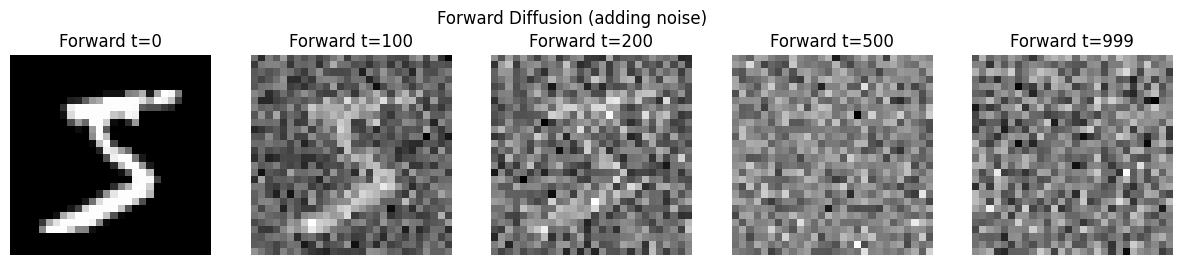

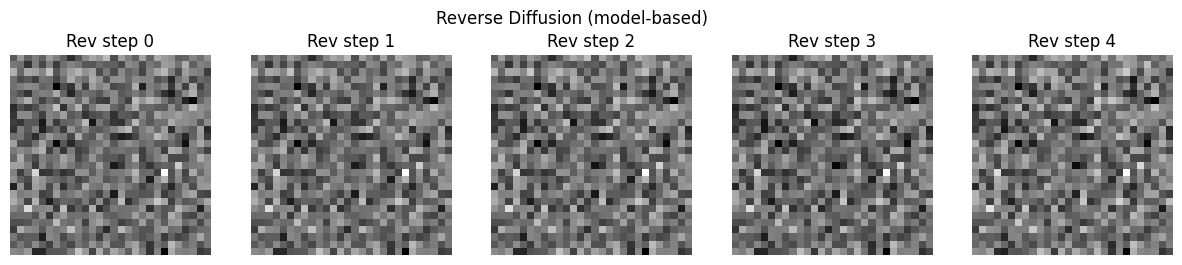

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tqdm import tqdm

# -------------------------
# 1. Define beta scheduler
# -------------------------
T = 1000
beta = np.linspace(1e-4, 0.02, T, dtype=np.float32)
alpha = 1.0 - beta
alpha_hat = np.cumprod(alpha)

beta = tf.convert_to_tensor(beta)
alpha = tf.convert_to_tensor(alpha)
alpha_hat = tf.convert_to_tensor(alpha_hat)

# -------------------------
# 2. Load and filter MNIST image
# -------------------------
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)

mask = np.logical_or(y_train == 2, y_train == 5)
x_train_f = x_train[mask]
x0 = tf.convert_to_tensor(x_train_f[0:1])  # (1, 28, 28, 1)

# -------------------------
# 3. Noise Prediction Model (ε_θ)
# -------------------------
def get_model():
    image_input = layers.Input(shape=(28, 28, 1))
    t_input = layers.Input(shape=(), dtype=tf.int32)

    # Embed timestep
    t_emb = layers.Embedding(input_dim=T, output_dim=32)(t_input)
    t_emb = layers.Dense(64, activation='relu')(t_emb)
    t_emb = layers.Dense(28 * 28, activation='relu')(t_emb)
    t_emb = layers.Reshape((28, 28, 1))(t_emb)

    x = layers.Concatenate()([image_input, t_emb])
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    out = layers.Conv2D(1, 1, padding='same')(x)
    return Model([image_input, t_input], out)

model = get_model()

# -------------------------
# 4. Train the model briefly
# -------------------------
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()

batch_size = 128
epochs = 3  # keep low for speed

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    idxs = np.random.permutation(len(x_train_f))
    for i in tqdm(range(0, len(x_train_f), batch_size)):
        x = x_train_f[idxs[i:i + batch_size]]
        x = tf.convert_to_tensor(x)
        t = tf.random.uniform((x.shape[0],), minval=0, maxval=T, dtype=tf.int32)
        noise = tf.random.normal(shape=x.shape)
        alpha_hat_t = tf.reshape(tf.gather(alpha_hat, t), [-1, 1, 1, 1])
        x_noisy = tf.sqrt(alpha_hat_t) * x + tf.sqrt(1 - alpha_hat_t) * noise

        with tf.GradientTape() as tape:
            noise_pred = model([x_noisy, t], training=True)
            loss = loss_fn(noise, noise_pred)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(f"Loss: {loss.numpy():.4f}")

# -------------------------
# 5. Forward diffusion (same as before)
# -------------------------
timesteps = [0, 100, 200, 500, 999]
noisy_imgs = [x0.numpy().squeeze()]
for t in timesteps[1:]:
    alpha_hat_t = tf.reshape(alpha_hat[t], (1, 1, 1, 1))
    noise = tf.random.normal(shape=x0.shape)
    x_t = tf.sqrt(alpha_hat_t) * x0 + tf.sqrt(1 - alpha_hat_t) * noise
    noisy_imgs.append(x_t.numpy().squeeze())
xT = x_t  # final noisy image

# -------------------------
# 6. Reverse diffusion using model
# -------------------------
reverse_imgs = []
x = xT
for t in reversed(range(0, T, T // 5)):
    t_tensor = tf.constant([t], dtype=tf.int32)
    t_batch = tf.repeat(t_tensor, repeats=x.shape[0])

    alpha_t = tf.reshape(alpha[t], (1, 1, 1, 1))
    alpha_hat_t = tf.reshape(alpha_hat[t], (1, 1, 1, 1))
    beta_t = tf.reshape(beta[t], (1, 1, 1, 1))

    noise_pred = model([x, t_batch], training=False)

    if t > 0:
        z = tf.random.normal(shape=x.shape)
    else:
        z = 0.0

    x = (1 / tf.sqrt(alpha_t)) * (x - ((1 - alpha_t) / tf.sqrt(1 - alpha_hat_t)) * noise_pred) + tf.sqrt(beta_t) * z

    reverse_imgs.append(x.numpy().squeeze())

reverse_imgs = reverse_imgs[::-1]

# -------------------------
# 7. Plot Forward
# -------------------------
plt.figure(figsize=(15, 3))
for i, img in enumerate(noisy_imgs):
    plt.subplot(1, len(noisy_imgs), i+1)
    plt.title(f"Forward t={timesteps[i]}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Forward Diffusion (adding noise)")
plt.show()

# -------------------------
# 8. Plot Reverse (with model)
# -------------------------
plt.figure(figsize=(15, 3))
for i, img in enumerate(reverse_imgs):
    plt.subplot(1, len(reverse_imgs), i+1)
    plt.title(f"Rev step {i}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Reverse Diffusion (model-based)")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

T = 1000  # define number of diffusion steps if not already defined

def get_denoise_model(input_shape=(28, 28, 1)):
    inputs = keras.Input(shape=input_shape)
    t_input = keras.Input(shape=(), dtype=tf.int32)

    # --- Time embedding ---
    t_emb = layers.Embedding(input_dim=T, output_dim=128)(t_input)
    t_emb = layers.Dense(256, activation="relu")(t_emb)
    t_emb = layers.Dense(28 * 28, activation="relu")(t_emb)
    t_emb = layers.Reshape((28, 28, 1))(t_emb)

    # --- Input + Time embedding merge ---
    x = layers.Concatenate()([inputs, t_emb])

    # --- Downsampling path ---
    c1 = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    c1 = layers.Conv2D(64, 3, padding="same", activation="relu")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, padding="same", activation="relu")(p1)
    c2 = layers.Conv2D(128, 3, padding="same", activation="relu")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    b = layers.Conv2D(256, 3, padding="same", activation="relu")(p2)
    b = layers.Conv2D(256, 3, padding="same", activation="relu")(b)

    # --- Upsampling path ---
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, 3, padding="same", activation="relu")(u1)
    c3 = layers.Conv2D(128, 3, padding="same", activation="relu")(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, 3, padding="same", activation="relu")(u2)
    c4 = layers.Conv2D(64, 3, padding="same", activation="relu")(c4)

    # --- Final output ---
    outputs = layers.Conv2D(1, 1, padding="same")(c4)

    return keras.Model([inputs, t_input], outputs)

# Build the model
model = get_denoise_model()
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128)       │    128,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 784)       │    201,488 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28, 2) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │      1,216 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 7, 7, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 7, 7, 256) │    590,080 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 14, 14,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 14, 14,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │    442,496 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,245,073 (8.56 MB)

 Trainable params: 2,245,073 (8.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ✅ Step 6: Train the model
optimizer = keras.optimizers.Adam(1e-3)
loss_fn = keras.losses.MeanSquaredError()

batch_size = 128
epochs = 20  # Increase for better results

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    idxs = np.random.permutation(len(x_train_f))

    for i in tqdm(range(0, len(x_train_f), batch_size)):
        x = x_train_f[idxs[i:i+batch_size]]
        t = np.random.randint(0, T, size=len(x))

        noise = np.random.randn(*x.shape).astype("float32")
        t = tf.random.uniform((x.shape[0],), minval=0, maxval=T, dtype=tf.int32)
        alpha_hat_t = tf.reshape(tf.gather(alpha_hat, t), [-1, 1, 1, 1])
        x_noisy = tf.sqrt(alpha_hat_t) * x + tf.sqrt(1 - alpha_hat_t) * noise

        with tf.GradientTape() as tape:
            noise_pred = model([x_noisy, t], training=True)
            loss = loss_fn(noise, noise_pred)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    print(f"Loss: {loss.numpy():.4f}")



Epoch 1/20


100%|██████████| 89/89 [00:32<00:00,  2.75it/s]


Loss: 0.0764

Epoch 2/20


100%|██████████| 89/89 [00:21<00:00,  4.08it/s]


Loss: 0.0522

Epoch 3/20


100%|██████████| 89/89 [00:22<00:00,  3.88it/s]


Loss: 0.0511

Epoch 4/20


100%|██████████| 89/89 [00:22<00:00,  3.95it/s]


Loss: 0.0409

Epoch 5/20


100%|██████████| 89/89 [00:22<00:00,  3.96it/s]


Loss: 0.0305

Epoch 6/20


100%|██████████| 89/89 [00:22<00:00,  3.97it/s]


Loss: 0.0272

Epoch 7/20


100%|██████████| 89/89 [00:22<00:00,  3.95it/s]


Loss: 0.0503

Epoch 8/20


100%|██████████| 89/89 [00:22<00:00,  3.96it/s]


Loss: 0.0255

Epoch 9/20


100%|██████████| 89/89 [00:22<00:00,  3.98it/s]


Loss: 0.0227

Epoch 10/20


100%|██████████| 89/89 [00:22<00:00,  3.95it/s]


Loss: 0.0268

Epoch 11/20


100%|██████████| 89/89 [00:22<00:00,  3.93it/s]


Loss: 0.0255

Epoch 12/20


100%|██████████| 89/89 [00:22<00:00,  3.94it/s]


Loss: 0.0277

Epoch 13/20


100%|██████████| 89/89 [00:22<00:00,  3.98it/s]


Loss: 0.0216

Epoch 14/20


100%|██████████| 89/89 [00:22<00:00,  3.94it/s]


Loss: 0.0357

Epoch 15/20


100%|██████████| 89/89 [00:22<00:00,  3.98it/s]


Loss: 0.0287

Epoch 16/20


100%|██████████| 89/89 [00:22<00:00,  4.01it/s]


Loss: 0.0291

Epoch 17/20


100%|██████████| 89/89 [00:22<00:00,  4.00it/s]


Loss: 0.0278

Epoch 18/20


100%|██████████| 89/89 [00:22<00:00,  3.97it/s]


Loss: 0.0273

Epoch 19/20


100%|██████████| 89/89 [00:22<00:00,  3.97it/s]


Loss: 0.0238

Epoch 20/20


100%|██████████| 89/89 [00:22<00:00,  3.98it/s]

Loss: 0.0218


In [ ]:
# ✅ Step 7: Sampling function
@tf.function
def sample_images(n=16):
    x = tf.random.normal((n, 28, 28, 1))
    for t_val in reversed(range(T)):
        t_batch = tf.fill((n,), t_val)
        alpha_t = alpha[t_val]
        alpha_hat_t = alpha_hat[t_val]
        beta_t = beta[t_val]

        z = tf.random.normal(x.shape) if t_val > 0 else 0
        eps_theta = model([x, t_batch], training=False)

        x = (1 / tf.sqrt(alpha_t)) * (x - (beta_t / tf.sqrt(1 - alpha_hat_t)) * eps_theta) + tf.sqrt(beta_t) * z
    return x


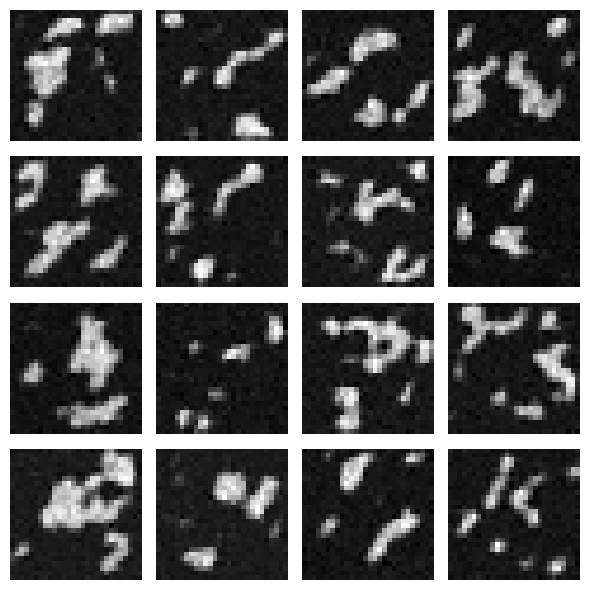

In [ ]:
# ✅ Step 8: Visualize generated samples
samples = sample_images(n=16)
samples = tf.squeeze(samples).numpy()

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()
